In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

In [2]:

# Đọc dữ liệu
df = pd.read_csv('Crude Oil WTI.csv')

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)


In [3]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190.0,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400.0,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400.0,-0.05
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,78.65,77.84,78.8,77.75,NaN,1.2
1915,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070.0,1.5
1916,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589.0,-0.75
1917,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780.0,-1.67


In [4]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

In [5]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190.0,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400.0,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400.0,-0.05
...,...,...,...,...,...,...,...
1787,2024-05-24 00:00:00,77.72,77.04,78.05,76.15,299080.0,1.11
1788,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070.0,1.5
1789,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589.0,-0.75
1790,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780.0,-1.67


In [6]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Cruide Oil

## 7:3

In [7]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [8]:
# Hàm tạo tập dữ liệu với look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


In [9]:
look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Định hình lại dữ liệu để phù hợp với mô hình
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [10]:
# Huấn luyện mô hình
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    random_state=42
)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42)

In [11]:
# Dự báo 
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [12]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 2.015113525141163
MAPE trên tập test là: 1.9557496137735813 %
MAE trên tập test là: 1.529016032730777


In [13]:

# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat.reshape(-1,1), axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)

Dự báo giá trị 90 ngày trong tương lai:
[[77.91379702]
 [78.41721899]
 [78.6205981 ]
 [78.57160425]
 [79.19490518]
 [79.25349202]
 [80.05853685]
 [81.00266172]
 [81.1028032 ]
 [81.75849203]
 [82.3073626 ]
 [83.17967997]
 [83.53268264]
 [83.70868972]
 [83.77089464]
 [83.68391365]
 [83.66060785]
 [83.66238135]
 [83.65479205]
 [83.67491198]
 [83.6704824 ]
 [83.75417894]
 [83.67886383]
 [83.60088383]
 [83.46813505]
 [83.17406295]
 [82.77823257]
 [82.49266626]
 [82.0560006 ]
 [81.75786904]
 [81.51604532]
 [81.52044146]
 [81.53664818]
 [81.48980157]
 [81.57713229]
 [81.76337478]
 [81.89629801]
 [82.29067727]
 [82.23237775]
 [82.23502632]
 [82.17865122]
 [82.14431976]
 [82.27578037]
 [82.13209347]
 [82.16382284]
 [82.33682944]
 [82.43322957]
 [82.39455401]
 [82.42805473]
 [82.51379258]
 [82.61612413]
 [82.60479231]
 [82.60464481]
 [82.73402329]
 [82.67445221]
 [82.57086542]
 [82.56808668]
 [82.55095883]
 [82.55575883]
 [82.58432549]
 [82.58297549]
 [82.58297549]
 [82.44074732]
 [82.26189722]


In [14]:

test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1792,77.913797
1793,78.417219
1794,78.620598
1795,78.571604
1796,79.194905
...,...
1877,82.504165
1878,82.441678
1879,82.504165
1880,82.504165


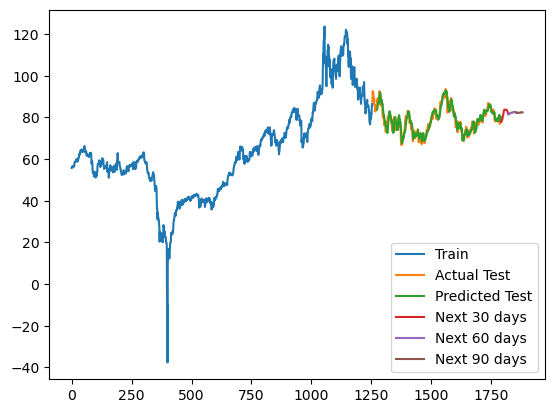

In [15]:

next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.savefig("RF_Cruide_Oil_Week6.png")
plt.legend()
plt.show()

## 8:2

In [16]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [17]:

# Hàm tạo tập dữ liệu với look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Định hình lại dữ liệu để phù hợp với mô hình
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [18]:
# Huấn luyện mô hình
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    random_state=42
)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42)

In [19]:
# Dự báo 
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [20]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 1.4924700855082107
MAPE trên tập test là: 1.4607337261901547 %
MAE trên tập test là: 1.1529961931517738


In [21]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat.reshape(-1,1), axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)


Dự báo giá trị 90 ngày trong tương lai:
[[76.47969147]
 [76.32519188]
 [75.90378736]
 [76.10218533]
 [75.93583958]
 [75.87707408]
 [75.94508974]
 [76.13807874]
 [76.28098657]
 [76.57572603]
 [76.32625809]
 [76.5042107 ]
 [76.79259714]
 [76.92147404]
 [77.4183023 ]
 [78.23463588]
 [78.43757343]
 [78.7849628 ]
 [78.85175261]
 [79.21710667]
 [79.26216054]
 [79.40248049]
 [79.54804541]
 [79.45111651]
 [79.33610568]
 [79.40897345]
 [79.04112678]
 [78.72820227]
 [78.30272894]
 [77.50589279]
 [77.30992809]
 [77.14925406]
 [76.7733563 ]
 [76.44622778]
 [76.18349158]
 [75.91238879]
 [75.44321731]
 [75.58472444]
 [75.97318025]
 [76.18887934]
 [76.42905558]
 [76.57241058]
 [76.77458855]
 [76.96848411]
 [77.59530992]
 [78.36057112]
 [78.47445506]
 [78.85601018]
 [79.15575186]
 [79.34886306]
 [79.50634638]
 [79.6332189 ]
 [79.83165053]
 [80.25608275]
 [80.43724595]
 [80.57325999]
 [80.75674553]
 [80.90197795]
 [80.96734456]
 [80.72951606]
 [80.50322628]
 [80.32480977]
 [80.07166921]
 [80.07311879]


In [22]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1792,76.479691
1793,76.325192
1794,75.903787
1795,76.102185
1796,75.935840
...,...
1877,79.336376
1878,79.567863
1879,79.506489
1880,79.597361


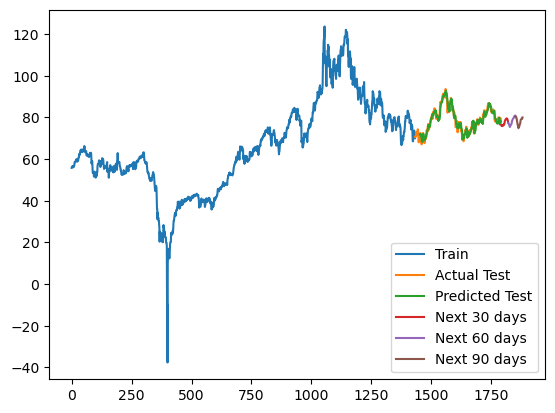

In [23]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()

### 9:1

In [24]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [25]:
# Hàm tạo tập dữ liệu với look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Định hình lại dữ liệu để phù hợp với mô hình
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [26]:
# Huấn luyện mô hình
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    random_state=42
)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42)

In [27]:
# Dự báo 
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [28]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 1.2606498457029796
MAPE trên tập test là: 1.274532015120314 %
MAE trên tập test là: 0.9892984413603346


In [29]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat.reshape(-1,1), axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)


Dự báo giá trị 90 ngày trong tương lai:
[[76.42976432]
 [76.1245847 ]
 [75.78736188]
 [75.82121878]
 [75.65674828]
 [75.53137205]
 [75.71361297]
 [76.07764083]
 [76.48674409]
 [76.75733006]
 [77.04564247]
 [77.50375854]
 [78.37943679]
 [78.76769422]
 [79.05294237]
 [79.0787279 ]
 [79.25777386]
 [79.47954235]
 [80.02414355]
 [80.66770642]
 [80.7248273 ]
 [80.5923097 ]
 [80.75572785]
 [80.78541768]
 [80.67637088]
 [80.55742341]
 [80.59204634]
 [80.50470528]
 [80.33131909]
 [80.06705764]
 [79.94162465]
 [80.04024722]
 [79.94464114]
 [79.84579747]
 [79.94147012]
 [79.87407901]
 [79.96073053]
 [79.89386626]
 [80.03437405]
 [79.89670878]
 [80.22026616]
 [79.91563486]
 [80.12942953]
 [80.01783046]
 [80.1633439 ]
 [80.10769808]
 [80.14759228]
 [80.13750963]
 [80.02231561]
 [80.09547797]
 [79.9778997 ]
 [80.05636131]
 [80.03564093]
 [80.00104881]
 [80.03564093]
 [79.94939426]
 [80.06669093]
 [79.95614637]
 [80.03992388]
 [80.02631303]
 [80.01973252]
 [80.08482553]
 [80.07401547]
 [80.15794258]


In [30]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1792,76.429764
1793,76.124585
1794,75.787362
1795,75.821219
1796,75.656748
...,...
1877,80.061628
1878,80.029113
1879,80.074015
1880,80.029113


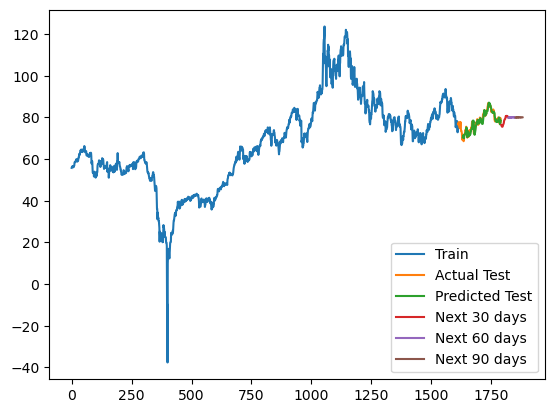

In [31]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()